In [39]:
import numpy as np
from io_utils import *
A = loadGraph('facebook/0.edges', 'u')
A = removeIsolatedNodes(A)

B, P = permuteNoiseMat(A,is_perm =False, has_noise=False)

writeEdgesToFile('metadata/A.edges', A)
writeEdgesToFile('metadata/B.edges', B)


In [40]:
from attr_utils import *

attributesA = getUndirAttribute('metadata/A.edges')
with open('metadata/attributesA', 'w') as f:
    for index, row in attributesA.iterrows():
        f.write(str(attributesA.ix[index]))

attributesB = getUndirAttribute('metadata/B.edges')
with open('metadata/attributesB', 'w') as f:
    for index, row in attributesB.iterrows():
        f.write(str(attributesB.ix[index]))

Degree


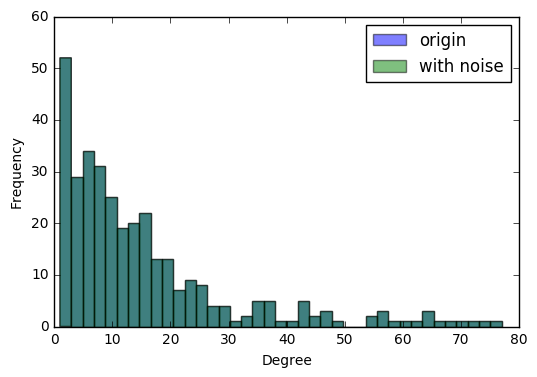

NodeBetweennessCentrality


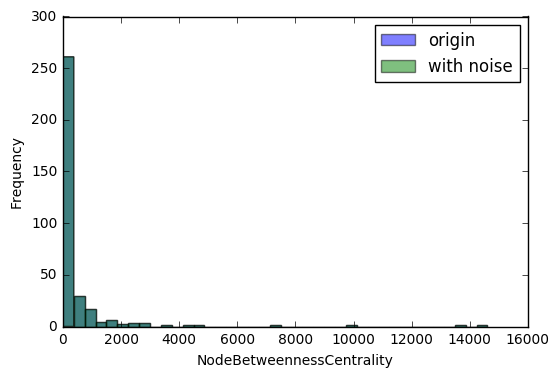

FarnessCentrality


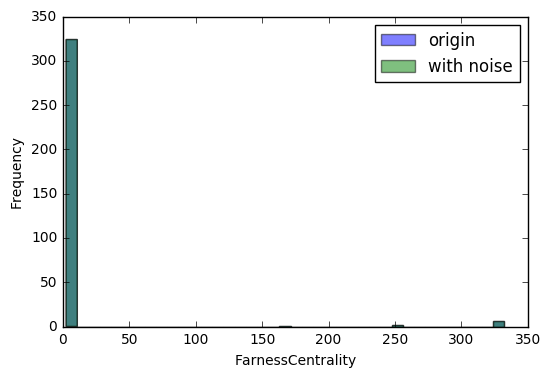

PageRank


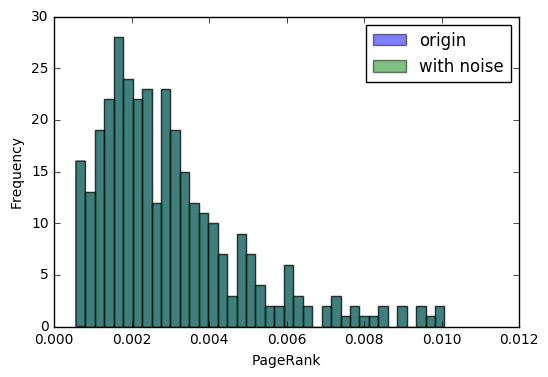

NodeEccentricity


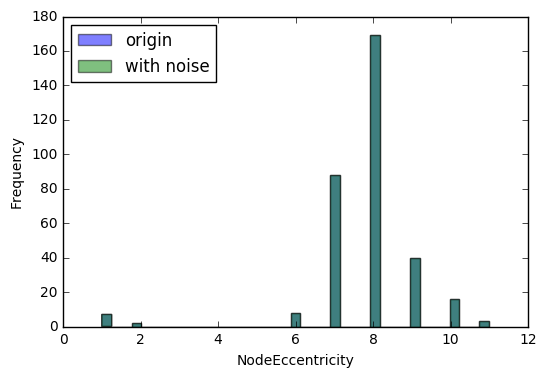

EgonetDegree


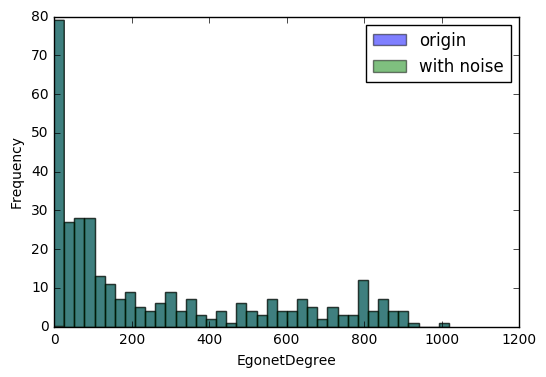

AvgNeighborDeg


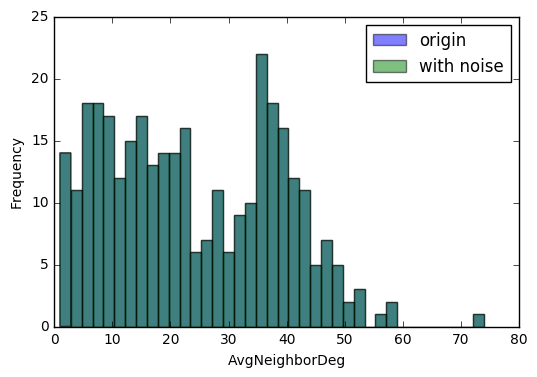

EgonetConnectivity


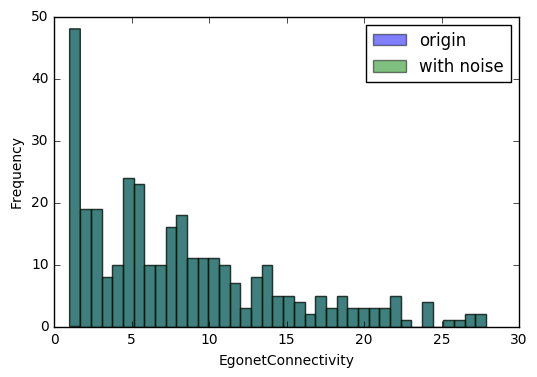

In [41]:
# plot attributes distributin against noise
import matplotlib.pyplot as plt

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity'
              , 'EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
plt.clf()
for attr in attributes:
    print attr
    plt.figure()
    bins = np.linspace(min(min(attributesA[attr]), min(attributesB[attr])), max(max(attributesA[attr]), max(attributesB[attr])), 40)
    plt.hist(attributesA[attr], bins, alpha=0.5, label='origin')
    plt.hist(attributesB[attr], bins, alpha=0.5, label='with noise')
    plt.xlabel(attr)
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

In [42]:
from attr_utils import *
from lsh_utils import *

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity']

for i in range(len(attributes)-1):
    for j in range(i+1, len(attributes)):
        print 'KL Divergence of %s and %s' %(attributes[i], attributes[j]), KL_sim(attributesA[attributes[i]], attributesA[attributes[j]])


KL Divergence of Degree and NodeBetweennessCentrality 401.589938548
KL Divergence of Degree and FarnessCentrality 568.918711733
KL Divergence of Degree and PageRank 41.976016422
KL Divergence of Degree and NodeEccentricity 155.839599134
KL Divergence of NodeBetweennessCentrality and FarnessCentrality 966.758801679
KL Divergence of NodeBetweennessCentrality and PageRank 356.539621748
KL Divergence of NodeBetweennessCentrality and NodeEccentricity 566.027214886
KL Divergence of FarnessCentrality and PageRank 650.238026988
KL Divergence of FarnessCentrality and NodeEccentricity 1049.71859395
KL Divergence of PageRank and NodeEccentricity 79.1235449177


In [43]:
from lsh_utils import *

combineAB = selectAndCombine(attributesA, attributesB)

bandDeg = ['Degree','PageRank','NodeBetweennessCentrality','FarnessCentrality']
bucketDeg = generateCosineBuckets(selectAndCombine(attributesA, attributesB, bandDeg), 20)
with open('metadata/buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
bucketEdge = generateCosineBuckets(selectAndCombine(attributesA, attributesB, bandEdge), 20)
with open('metadata/buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateCosineBuckets(selectAndCombine(attributesA, attributesB, bandAll), 20)
print len(bucketAll.items())

buckets = [bucketDeg, bucketEdge]

33
31
35


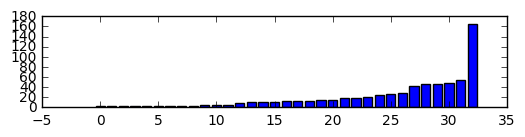

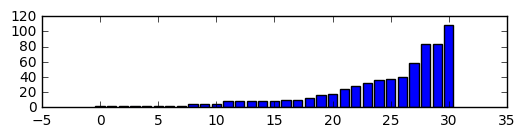

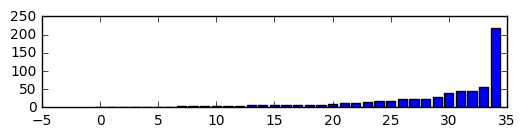

In [44]:
#plot cosine bucket distribution
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(313)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

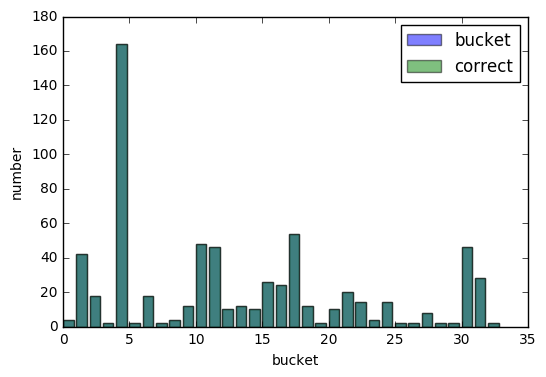

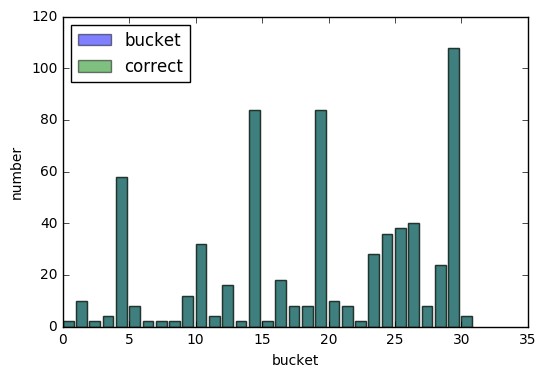

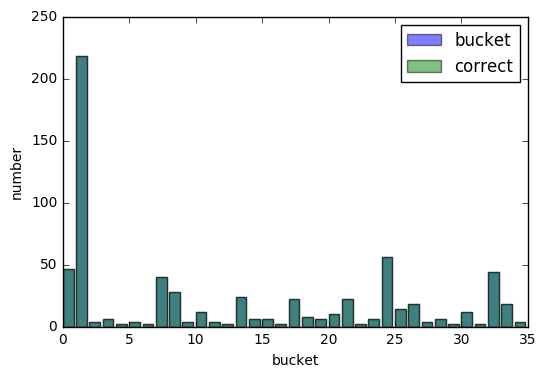

In [45]:
# plot cosine bucket correctness
def plotCorrectness(d, n):
    correct = {}
    for v, k in d.items():
        cnt = 0
        for i in k:
            if (i < n):
                if (i + n in k):
                    cnt += 2
            else:
                break
        correct[v] = cnt
    plt.clf
    plt.figure()
    plt.bar(range(len(d)), [len(v) for k,v in d.items()], alpha=0.5, label='bucket', color='blue')
    plt.bar(range(len(correct)), [correct[k] for k,v in d.items()], alpha=0.5, label='correct', color='green')
    plt.xlabel('bucket')
    plt.ylabel('number')
    plt.legend(loc='best')
    plt.show()
    
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [46]:
matching_matrix = computeMatchingMat(attributesA, attributesB, pair_count_dict)
sim_matrix = computeWholeSimMat(attributesA, attributesB)
Ranking = Rank(matching_matrix, P)
Best_ranking = Rank(sim_matrix, P)

In [58]:
print Best_ranking
print "matching score: %f" %(sum(Ranking)/len(Ranking))
print "matching score upper bound: %f" %(sum(Best_ranking)/len(Best_ranking))
print "percentage of pairs computed: %f" %(len(pair_count_dict)
                                           /float(matching_matrix.shape[0]*matching_matrix.shape[1]/2-matching_matrix.shape[0]))

show_list = [0, 10, 20, 50]
top_k = 5
for i in show_list:
    print "cos sim top %d for node %d:" %(top_k, attributesA['Id'][i])
    print attributesB['Id'][sim_matrix[i].argsort()[-top_k:]].values
    print "matching top %d for node %d:"%(top_k, attributesA['Id'][i])
    print attributesB['Id'][matching_matrix[i].argsort()[-top_k:]].values


[ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   0.5  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1. 

In [53]:
bandDeg = ['Degree','PageRank','NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketDeg = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB, bandDeg), 2)
with open('metadata/euc-buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
bucketEdge = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB, bandEdge), 2)
with open('metadata/euc-buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB, bandAll), 2)
print len(bucketAll.items())
buckets = [bucketDeg, bucketEdge]

41
28
58


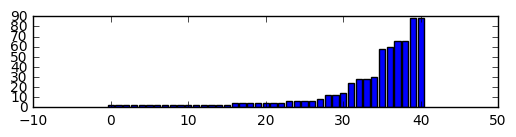

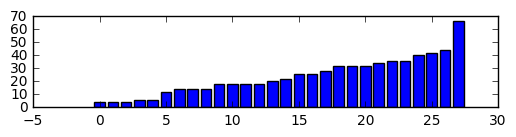

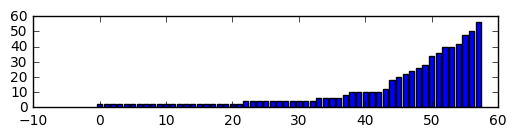

In [54]:
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(312)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

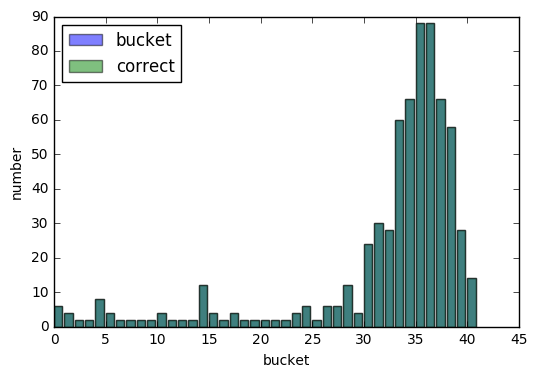

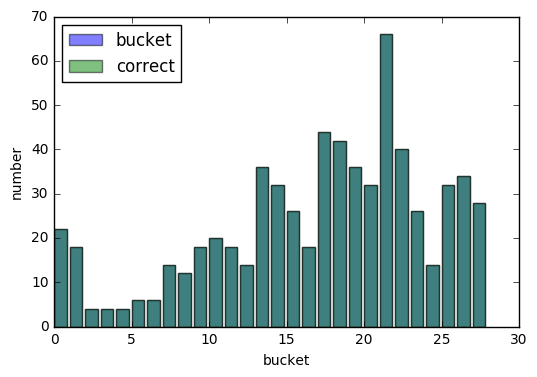

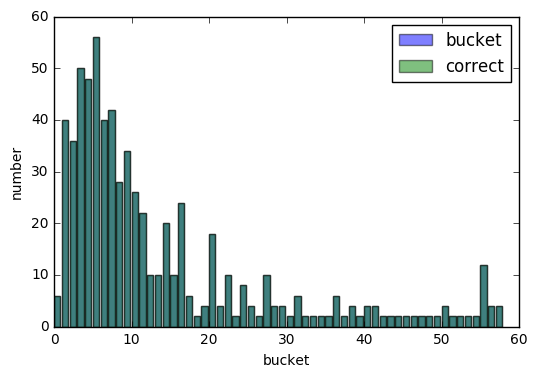

In [55]:
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [56]:
matching_matrix = computeMatchingMat(attributesA, attributesB, pair_count_dict)
sim_matrix = computeWholeSimMat(attributesA, attributesB)
Ranking = Rank(matching_matrix, P)
Best_ranking = Rank(sim_matrix, P)

print "matching score: %f" %(sum(Ranking)/len(Ranking))
print "matching score upper bound: %f" %(sum(Best_ranking)/len(Best_ranking))
print "percentage of pairs computed: %f" %(len(pair_count_dict)
                                           /float(matching_matrix.shape[0]*matching_matrix.shape[1]/2-matching_matrix.shape[0]))


matching score: 0.996997
matching score upper bound: 0.996997
percentage of pairs computed: 0.238773
